In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'

In [2]:
df = pd.read_csv('../Data/hysteresis/attachments/hys_kjh.csv')

In [3]:
df.head(3)

,Unnamed: 0,e,f
0,1,0.000000,0.000000
1,2,0.000000,0.015758
2,3,0.000234,0.030466


<Axes: >

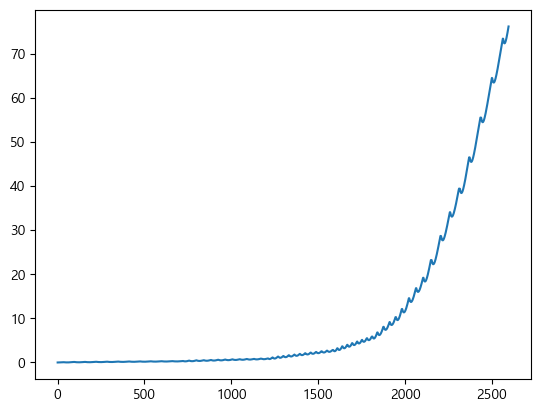

In [4]:
df.e.plot()

<Axes: >

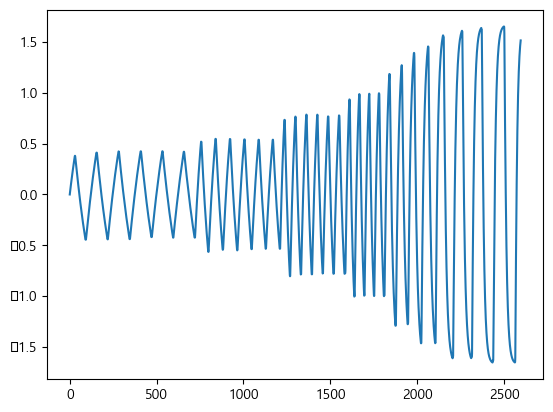

In [5]:
df.f.plot()

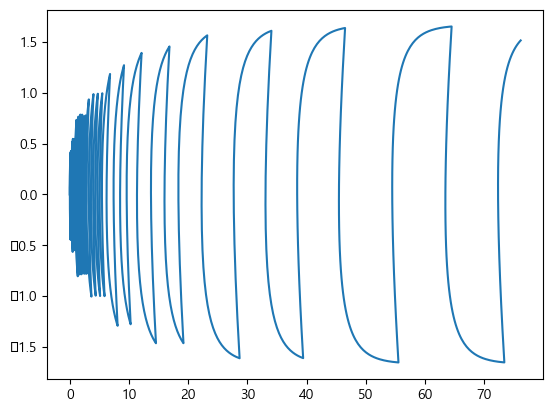

In [6]:
plt.plot(df.iloc[:,1], df.iloc[:,2])

In [7]:
df = df.iloc[:,1:]

<Axes: >

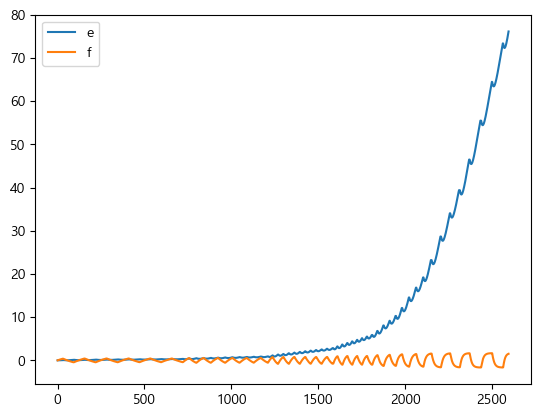

In [8]:
df.plot()

In [9]:
#hysteresis curve equation
def hys_curve(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


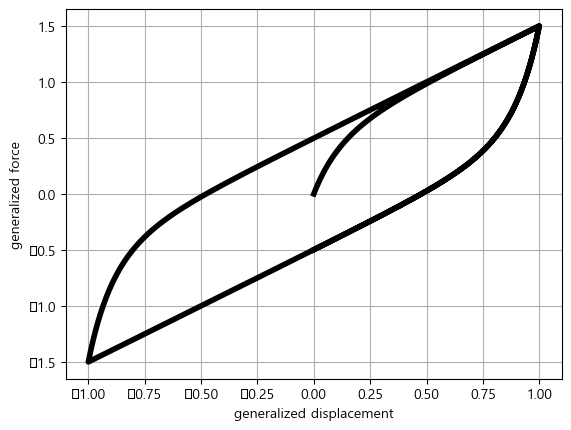

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 1.5 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# 1. INITIAL SETTINGS
# 1.1 Set the five model parameters
ka = 10.0
kb = 1.0
alfa = 10.0
beta1 = 0.0
beta2 = 0.0

# 1.2 Compute the internal model parameters
u0 = 0.5 * (((ka - kb) / 1e-20) ** (1 / alfa) - 1)
f0 = ((ka - kb) / 2) * (((1 + 2 * u0) ** (1 - alfa) - 1) / (1 - alfa))

# 1.3 Initialize the generalized force vector
f = np.zeros(n)

# 2. CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # 2.1 Update the history variable
    uj = u[i - 1] + np.sign(v[i]) * (1 + 2 * u0) - np.sign(v[i]) * (((np.sign(v[i]) * (1 - alfa)) / (ka - kb)) * (f[i - 1] - beta1 * u[i - 1] ** 3 - beta2 * u[i - 1] ** 5 - kb * u[i - 1] - np.sign(v[i]) * f0 + (ka - kb) * (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))))) ** (1 / (1 - alfa))

    # 2.2 Evaluate the generalized force at time t
    if (np.sign(v[i]) * uj) - 2 * u0 < np.sign(v[i]) * u[i] or np.sign(v[i]) * u[i] < np.sign(v[i]) * uj:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + (ka - kb) * ((((1 + 2 * u0 + np.sign(v[i]) * (u[i] - uj)) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))) - (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa)))) + np.sign(v[i]) * f0
    else:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + np.sign(v[i]) * f0

# PLOT
plt.figure()
plt.plot(u, f, 'k', linewidth=4)
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.grid()
plt.show()


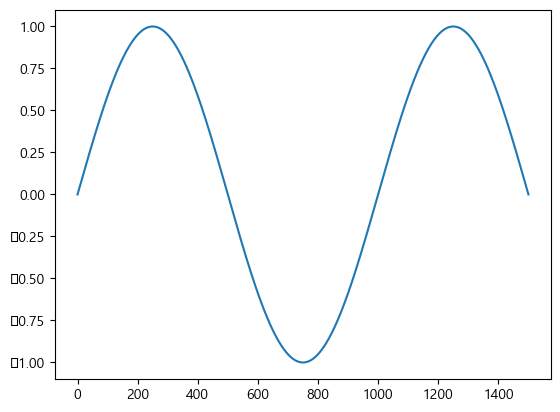

In [11]:
plt.plot(u)

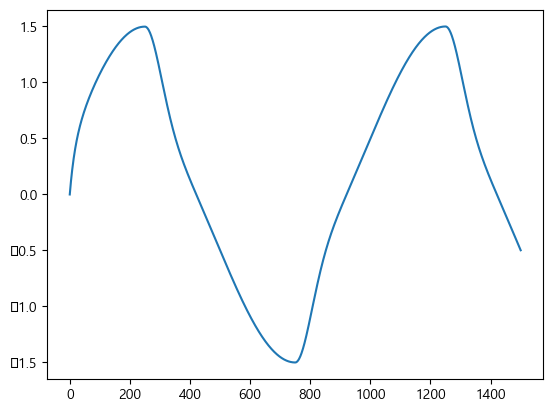

In [12]:
plt.plot(f)

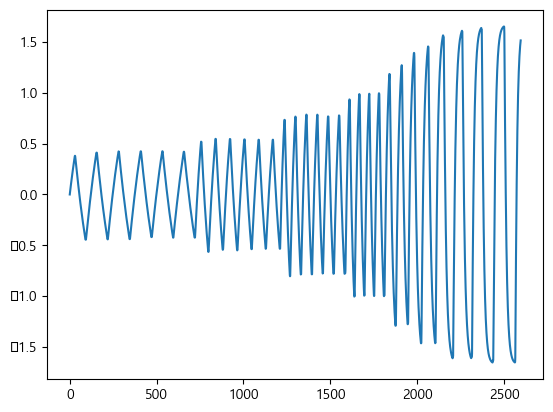

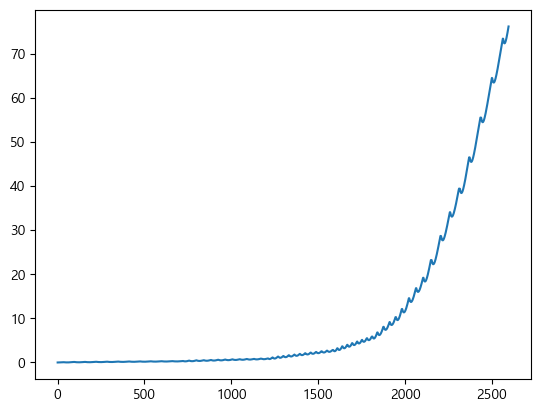

In [13]:
plt.plot(df.iloc[:,1])
plt.show()
plt.plot(df.iloc[:,0])
plt.show()

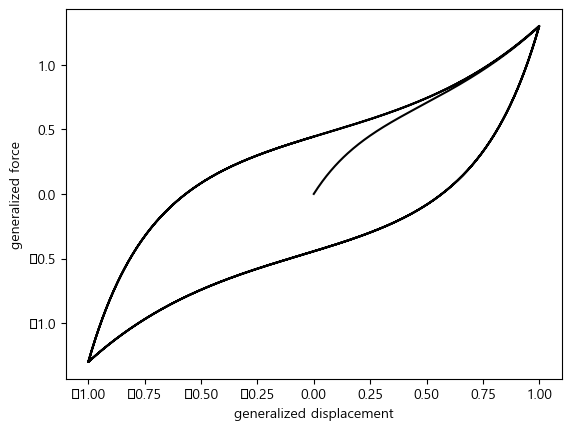

In [14]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()

In [17]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [18]:
total = pd.DataFrame()

In [19]:
total['u'] = u
total['time'] = t
total['f'] = f


In [20]:
total

,u,time,f
0,0.000000e+00,0.000,0.000000
1,6.283144e-03,0.001,0.017059
2,1.256604e-02,0.002,0.033687
3,1.884844e-02,0.003,0.049898
4,2.513010e-02,0.004,0.065705
...,...,...,...
2996,-2.513010e-02,2.996,0.430554
2997,-1.884844e-02,2.997,0.433910
2998,-1.256604e-02,2.998,0.437259
2999,-6.283144e-03,2.999,0.440601


In [21]:
x = total.iloc[:,0:2]
y = total.f

In [22]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

In [23]:
x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

----
## LSTM

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=(2, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [26]:
adam = optimizers.Adam(lr=0.01)

In [27]:
model.compile(loss = 'mse', optimizer = adam, metrics = 'mse')

In [28]:
history = model.fit(x_tr, y_tr, epochs = 500)

Epoch 1/500
63/63 [==============================] - 3s 2ms/step - loss: 0.1936 - mse: 0.1936
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1370 - mse: 0.1370
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1184 - mse: 0.1184
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1096 - mse: 0.1096
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1044 - mse: 0.1044
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1026 - mse: 0.1026
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1028 - mse: 0.1028
Epoch 8/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1023 - mse: 0.1023
Epoch 9/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0985 - mse: 0.0985
Epoch 10/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0933 - mse: 0.0933
Epoch 11/500
63/63 [==============================] - 0s 2m

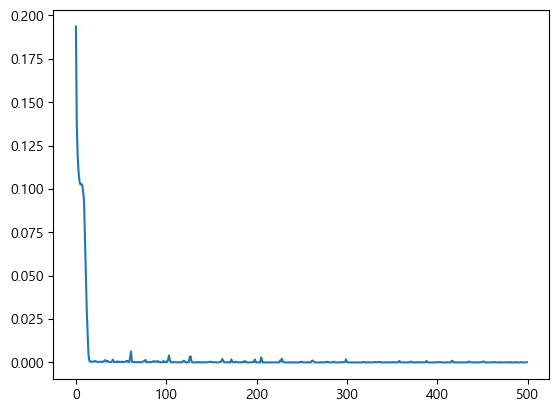

In [29]:
plt.plot(history.history['loss'])

In [30]:
pred = model.predict(x_te)

32/32 [==============================] - 1s 774us/step


In [31]:
pred = pred.reshape(-1,1)

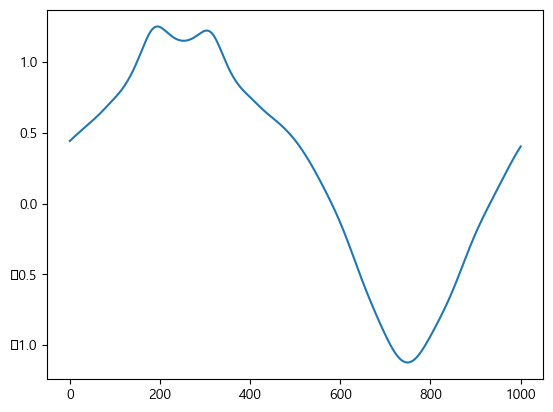

In [32]:
plt.plot(pred)

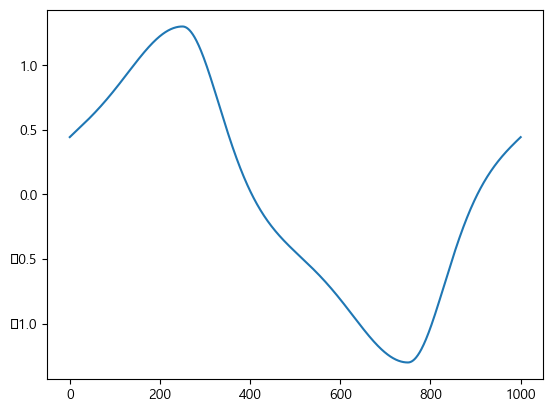

In [33]:
plt.plot(y_te)

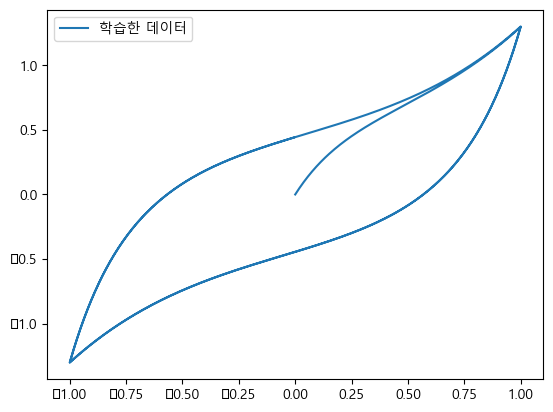

In [34]:
plt.plot(x.iloc[:2000,0], y.iloc[:2000], label = '학습한 데이터')
plt.legend()
plt.show()

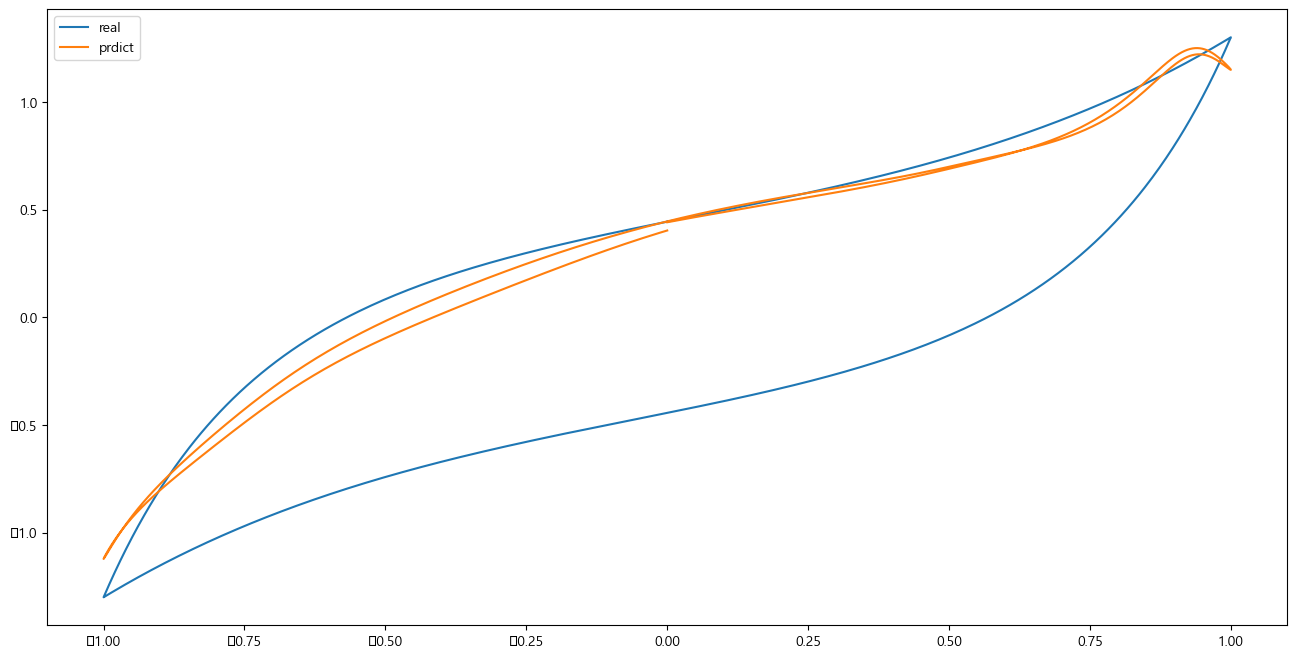

In [35]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred, label = 'prdict')
plt.legend()
plt.show()

----
## DNN

In [36]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(32, input_shape=(2,)))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = adam)

In [37]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,849
Trainable params: 18,849
Non-trainable params: 0
_________________________________________________________________


In [38]:
dnn = model_2.fit(x_tr, y_tr, epochs=500)

Epoch 1/500
63/63 [==============================] - 0s 645us/step - loss: 0.9078
Epoch 2/500
63/63 [==============================] - 0s 613us/step - loss: 0.1434
Epoch 3/500
63/63 [==============================] - 0s 613us/step - loss: 0.1156
Epoch 4/500
63/63 [==============================] - 0s 629us/step - loss: 0.1132
Epoch 5/500
63/63 [==============================] - 0s 629us/step - loss: 0.1138
Epoch 6/500
63/63 [==============================] - 0s 629us/step - loss: 0.1037
Epoch 7/500
63/63 [==============================] - 0s 613us/step - loss: 0.1057
Epoch 8/500
63/63 [==============================] - 0s 613us/step - loss: 0.1042
Epoch 9/500
63/63 [==============================] - 0s 622us/step - loss: 0.1040
Epoch 10/500
63/63 [==============================] - 0s 629us/step - loss: 0.1027
Epoch 11/500
63/63 [==============================] - 0s 629us/step - loss: 0.1038
Epoch 12/500
63/63 [==============================] - 0s 629us/step - loss: 0.1071
Epoch 13/500


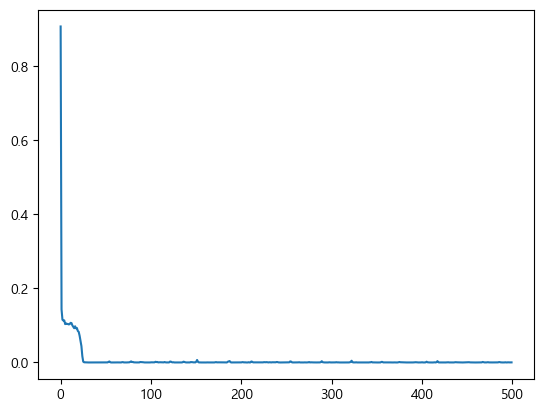

In [39]:
plt.plot(dnn.history['loss'])

In [40]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 484us/step


In [41]:
pred_2 = pred_2.reshape(-1,1)

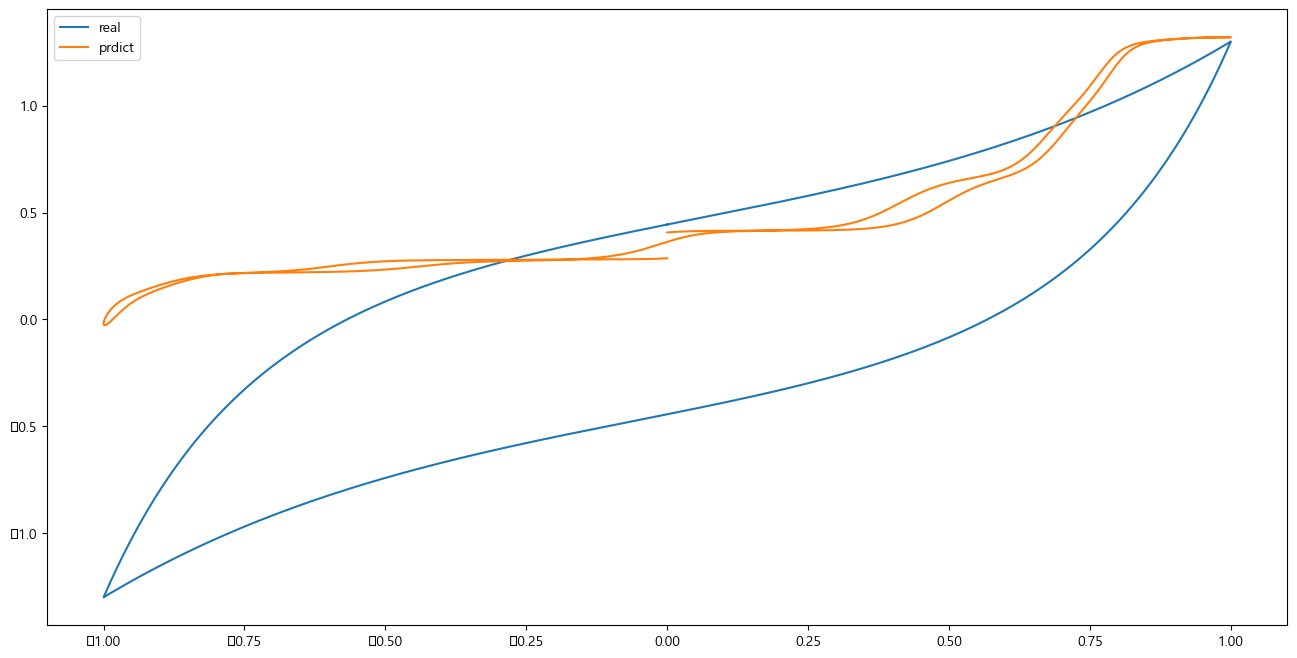

In [42]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred_2, label = 'prdict')
plt.legend()
plt.show()

---
## PINN

In [43]:
x0, y0 = 0, 0
w = 0.5
mu = 0.1

In [44]:
from scipy.integrate import odeint
from math import *

In [45]:
-2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

0.4439361230004127

In [46]:
def xt(x, t):
    return -2*beta*x[1] + np.exp(beta*x[1]) - np.exp(-beta*x[1]) + kb*x[1] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(x[1]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [47]:
xt([1,2,3,4,5],1)

4.703720540394448

In [65]:
xt([1,2],1)

4.703720540394448

In [67]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [68]:
model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

ephoch = 3000

In [69]:
with tf.GradientTape() as tape:
    tape.watch(x_tr)
    u = model(x_tr)
    du_dx = tape.gradient(u, x_tr)

In [70]:
model.trainable_variables

[<tf.Variable 'pinn_4/dense_18/kernel:0' shape=(2, 128) dtype=float32, numpy=
 array([[ 0.07173394,  0.04203136,  0.11463712,  0.17068948,  0.19918604,
         -0.07556534,  0.07005556, -0.01199841,  0.17496906, -0.00636835,
         -0.13806745, -0.02515738,  0.19503476,  0.0839438 , -0.12562466,
         -0.05103137, -0.19436474,  0.15107895, -0.15288062, -0.10162004,
         -0.03450368, -0.07696781,  0.11509387,  0.01293564,  0.15349968,
         -0.05132507, -0.15297809, -0.14053956,  0.13994698,  0.01654613,
         -0.02077797,  0.08324791, -0.13051687,  0.13922687,  0.0884742 ,
          0.18391843, -0.06637315,  0.10798989,  0.18463142, -0.1374053 ,
          0.02873845,  0.01529188, -0.02934127, -0.05388261, -0.02613297,
          0.05567242, -0.1479185 , -0.11590032, -0.19643503,  0.00220945,
          0.01991239,  0.19267412,  0.13593923, -0.21250367,  0.19529568,
          0.062535  , -0.0649842 ,  0.12464045,  0.09682448, -0.02615592,
         -0.13665715,  0.06852184,

In [62]:
du_dx

<tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
array([[-0.02168612,  0.10435967],
       [-0.02168602,  0.10435957],
       [-0.02168565,  0.10435918],
       ...,
       [-0.01811834,  0.0437536 ],
       [-0.0181157 ,  0.04373848],
       [-0.01811278,  0.04372369]])>